<a href="https://colab.research.google.com/github/RahafSobh/RahafSobh/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train 1: male.wav fs: 16000 samples: 64000
Train 2: female.wav fs: 16000 samples: 58960


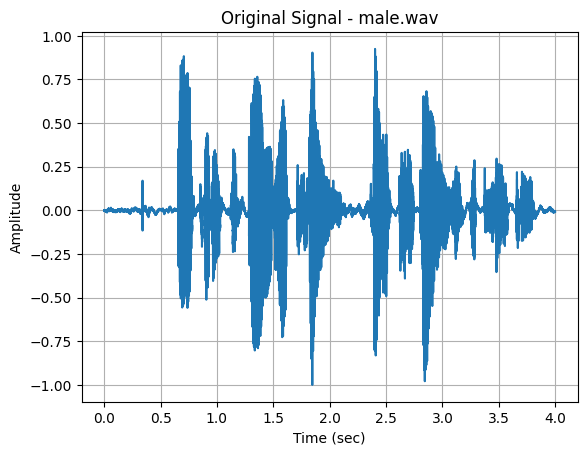

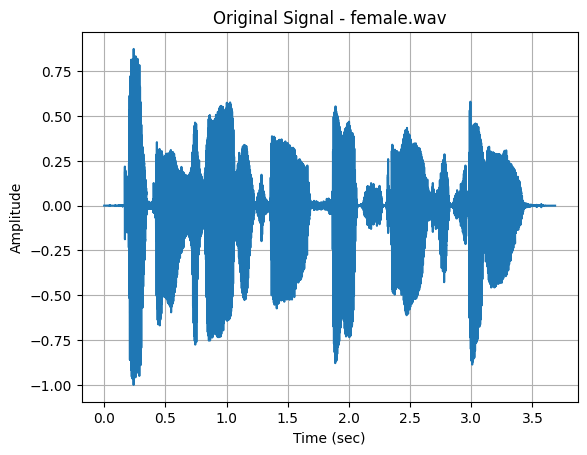

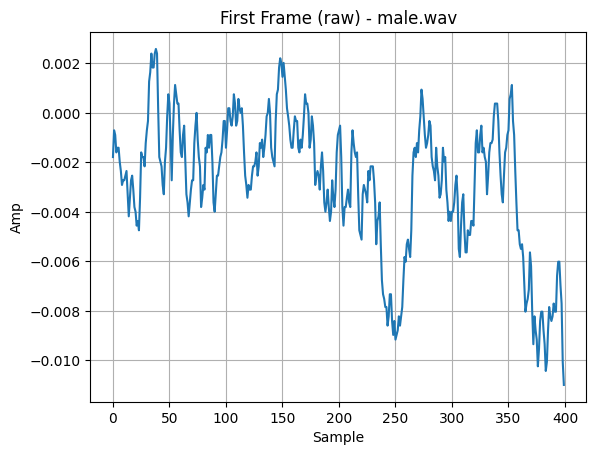

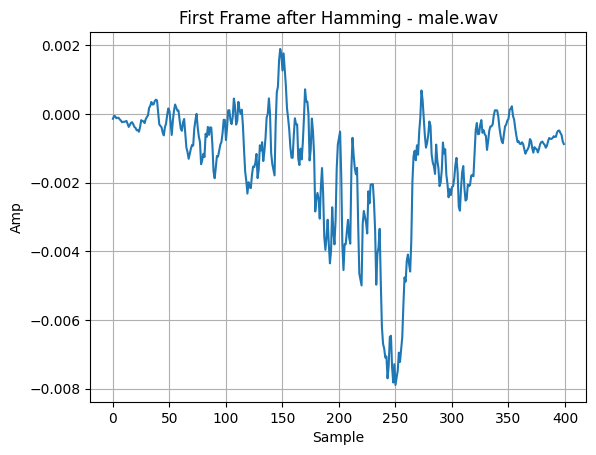

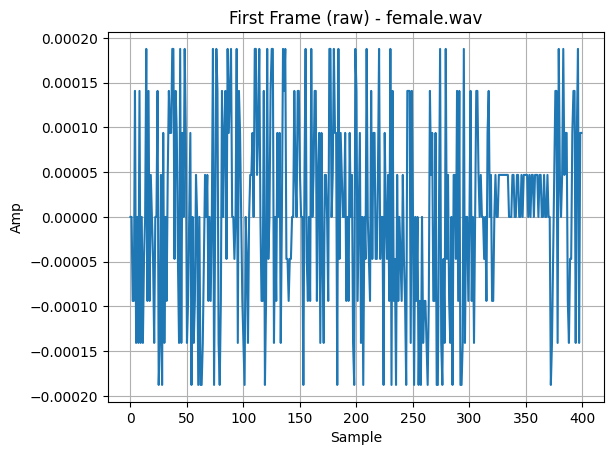

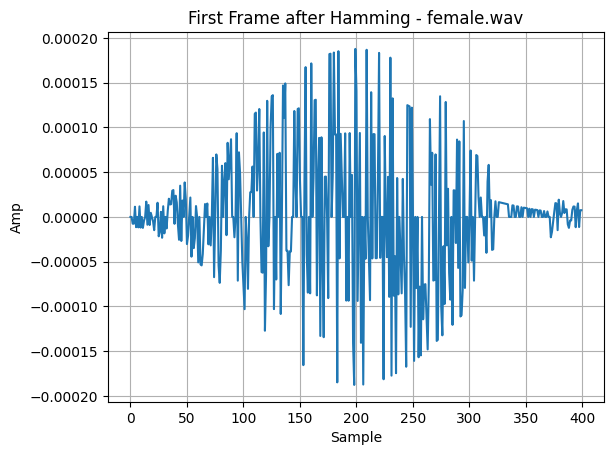

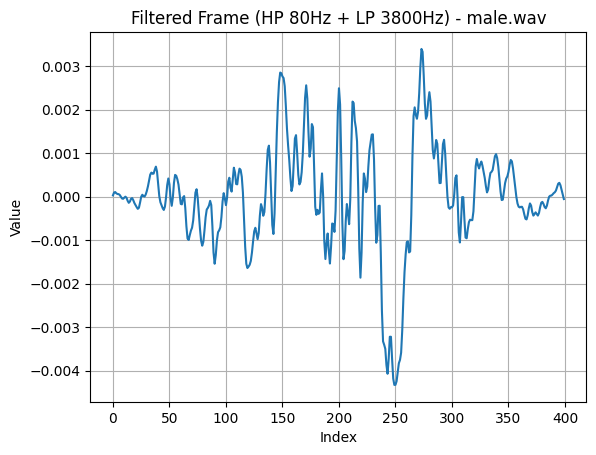

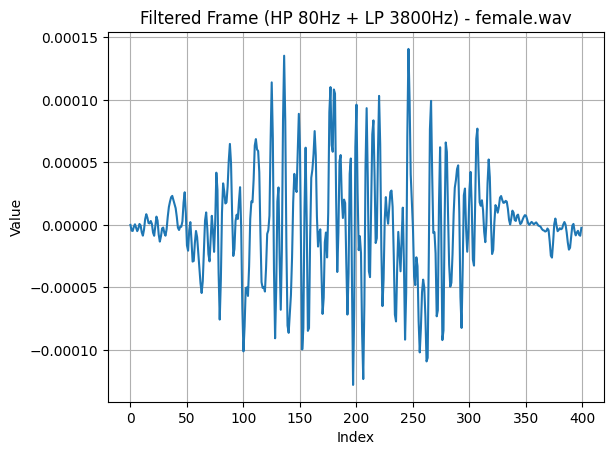

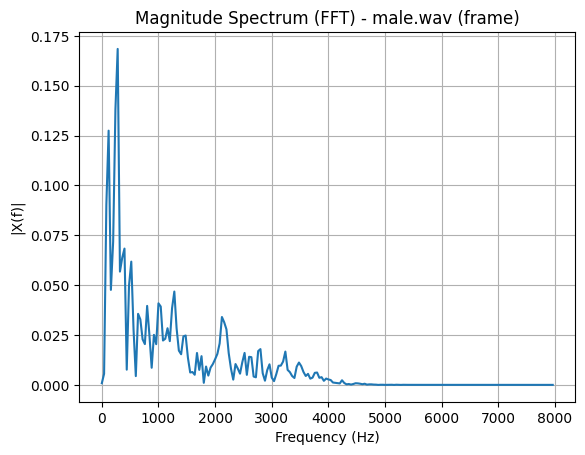

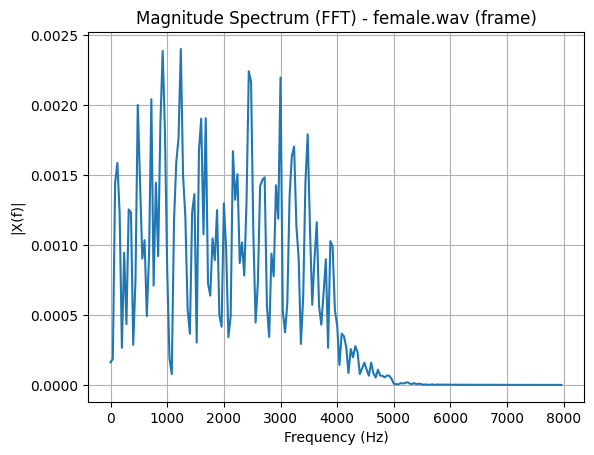

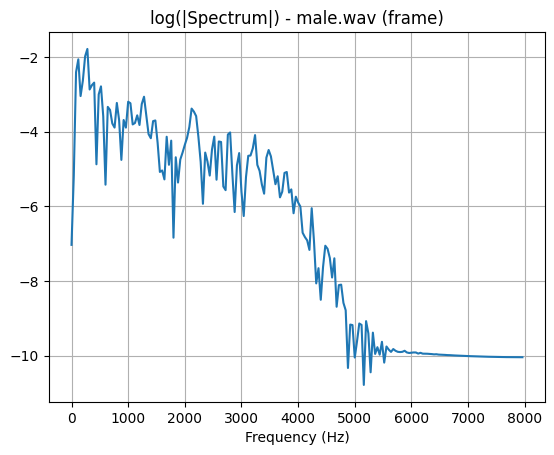

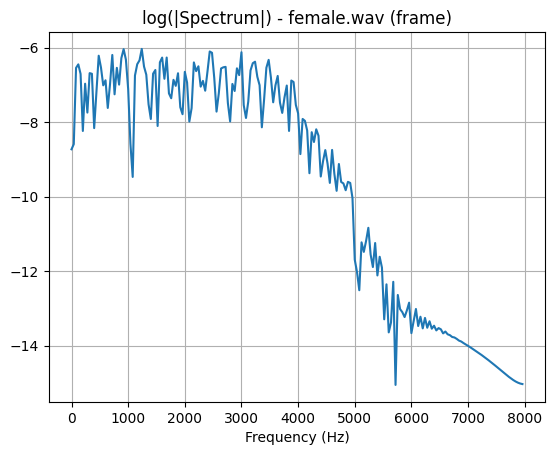

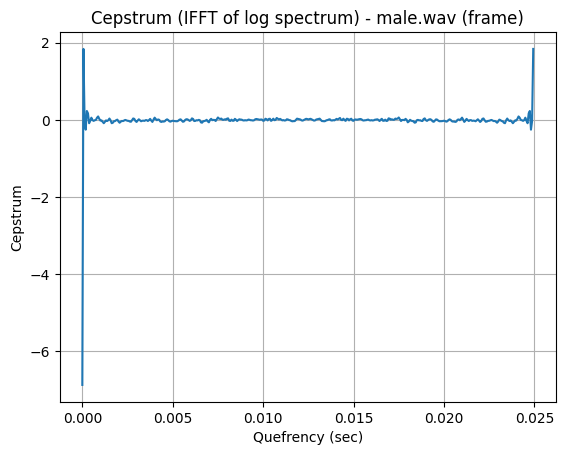

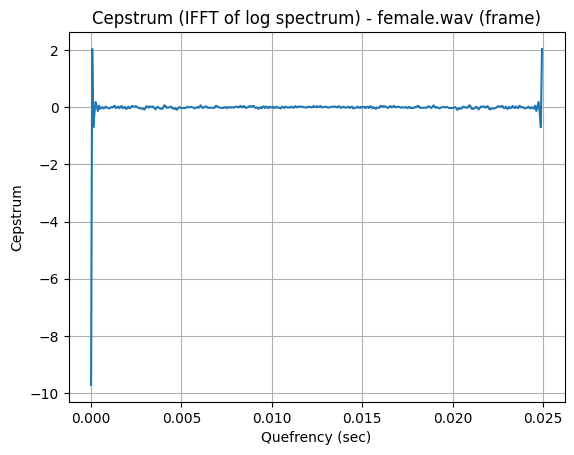

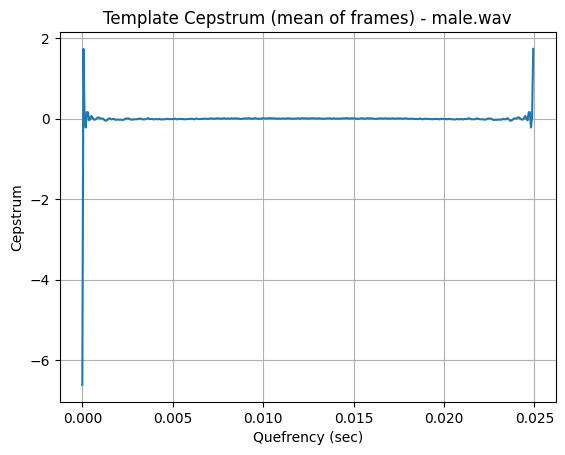

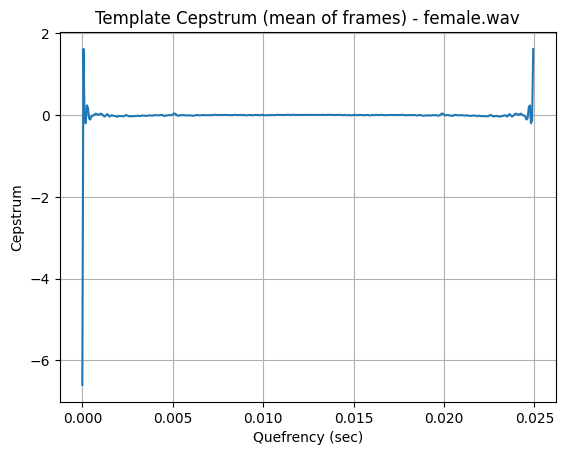


--- Cosine Similarity Results ---
male_4_test.wav: cos(to male)=0.9986, cos(to female)=0.9981  -> closer to male template
female_4_test.wav: cos(to male)=0.9758, cos(to female)=0.9734  -> closer to male template


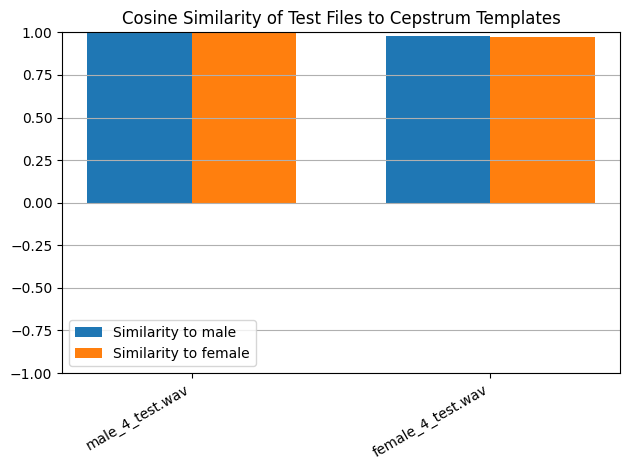

In [4]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, windows


file_train_1 = "male.wav"
file_train_2 = "female.wav"

test_files = ["male_4_test.wav", "female_4_test.wav"]

def load_wav(path: str):
    fs, x = wavfile.read(path)


    if x.ndim == 2:
        x = x.mean(axis=1)

    x = x.astype(np.float32)

    # Normalize to [-1,1]
    m = np.max(np.abs(x))
    if m > 0:
        x = x / m

    return fs, x

def plot_signal(x, fs, title):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (sec)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_series(y, title, xlabel="Index", ylabel="Value"):
    plt.figure()
    plt.plot(y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def butter_filter(x, fs, ftype, cutoff_hz, order=4):
    nyq = fs / 2.0
    Wn = cutoff_hz / nyq
    b, a = butter(order, Wn, btype=ftype)
    return filtfilt(b, a, x)

def compute_fft_full(x, fs):
    # Full FFT (complex)
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(len(x), d=1/fs)
    mag = np.abs(X)
    return freqs, X, mag

def plot_spectrum_half(freqs, mag, title):
    # show only positive frequencies
    half = len(freqs) // 2
    plt.figure()
    plt.plot(freqs[:half], mag[:half])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|X(f)|")
    plt.title(title)
    plt.grid(True)
    plt.show()

def cosine_sim(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    den = (np.linalg.norm(a) * np.linalg.norm(b))
    if den == 0:
        return 0.0
    return float(np.dot(a, b) / den)


frame_ms = 25
hop_ms = 10
max_frames = 25

hp_cut = 80
lp_cut = 3800
eps = 1e-10


fs_m, x_m = load_wav(file_train_1)
fs_f, x_f = load_wav(file_train_2)

print("Train 1:", file_train_1, "fs:", fs_m, "samples:", len(x_m))
print("Train 2:", file_train_2, "fs:", fs_f, "samples:", len(x_f))

plot_signal(x_m, fs_m, "Original Signal - male.wav")
plot_signal(x_f, fs_f, "Original Signal - female.wav")

def first_frame(x, fs, frame_ms):
    N = int(fs * frame_ms / 1000)
    return x[:N]

frame_m = first_frame(x_m, fs_m, frame_ms)
frame_f = first_frame(x_f, fs_f, frame_ms)

ham_m = windows.hamming(len(frame_m))
ham_f = windows.hamming(len(frame_f))

win_m = frame_m * ham_m
win_f = frame_f * ham_f

plot_series(frame_m, "First Frame (raw) - male.wav", xlabel="Sample", ylabel="Amp")
plot_series(win_m, "First Frame after Hamming - male.wav", xlabel="Sample", ylabel="Amp")

plot_series(frame_f, "First Frame (raw) - female.wav", xlabel="Sample", ylabel="Amp")
plot_series(win_f, "First Frame after Hamming - female.wav", xlabel="Sample", ylabel="Amp")


filt_m = butter_filter(win_m, fs_m, "highpass", hp_cut)
filt_m = butter_filter(filt_m, fs_m, "lowpass", lp_cut)

filt_f = butter_filter(win_f, fs_f, "highpass", hp_cut)
filt_f = butter_filter(filt_f, fs_f, "lowpass", lp_cut)

plot_series(filt_m, f"Filtered Frame (HP {hp_cut}Hz + LP {lp_cut}Hz) - male.wav")
plot_series(filt_f, f"Filtered Frame (HP {hp_cut}Hz + LP {lp_cut}Hz) - female.wav")

freqs_m, X_m, mag_m = compute_fft_full(filt_m, fs_m)
freqs_f, X_f, mag_f = compute_fft_full(filt_f, fs_f)

plot_spectrum_half(freqs_m, mag_m, "Magnitude Spectrum (FFT) - male.wav (frame)")
plot_spectrum_half(freqs_f, mag_f, "Magnitude Spectrum (FFT) - female.wav (frame)")


logmag_m = np.log(mag_m + eps)
logmag_f = np.log(mag_f + eps)


half_m = len(freqs_m) // 2
half_f = len(freqs_f) // 2

plt.figure()
plt.plot(freqs_m[:half_m], logmag_m[:half_m])
plt.title("log(|Spectrum|) - male.wav (frame)")
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(freqs_f[:half_f], logmag_f[:half_f])
plt.title("log(|Spectrum|) - female.wav (frame)")
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.show()

cep_m = np.fft.ifft(logmag_m).real
cep_f = np.fft.ifft(logmag_f).real

def plot_cepstrum(c, fs, title):
    q = np.arange(len(c)) / fs
    plt.figure()
    plt.plot(q, c)
    plt.title(title)
    plt.xlabel("Quefrency (sec)")
    plt.ylabel("Cepstrum")
    plt.grid(True)
    plt.show()

plot_cepstrum(cep_m, fs_m, "Cepstrum (IFFT of log spectrum) - male.wav (frame)")
plot_cepstrum(cep_f, fs_f, "Cepstrum (IFFT of log spectrum) - female.wav (frame)")


def cepstrum_from_frame(frame, fs):
    fr = butter_filter(frame, fs, "highpass", hp_cut)
    fr = butter_filter(fr, fs, "lowpass", lp_cut)

    X = np.fft.fft(fr)
    logmag = np.log(np.abs(X) + eps)
    c = np.fft.ifft(logmag).real
    return c

def build_template(x, fs, frame_ms=25, hop_ms=10, max_frames=25):
    N = int(fs * frame_ms / 1000)
    hop = int(fs * hop_ms / 1000)
    ham = windows.hamming(N)

    ceps = []
    for start in range(0, len(x) - N, hop):
        fr = x[start:start+N]
        fr = fr * ham
        c = cepstrum_from_frame(fr, fs)
        ceps.append(c)
        if len(ceps) >= max_frames:
            break

    ceps = np.array(ceps)
    return ceps.mean(axis=0)


template_m = build_template(x_m, fs_m, frame_ms=frame_ms, hop_ms=hop_ms, max_frames=max_frames)
template_f = build_template(x_f, fs_f, frame_ms=frame_ms, hop_ms=hop_ms, max_frames=max_frames)


plot_cepstrum(template_m, fs_m, "Template Cepstrum (mean of frames) - male.wav")
plot_cepstrum(template_f, fs_f, "Template Cepstrum (mean of frames) - female.wav")

results = []
for tf in test_files:
    fs_t, x_t = load_wav(tf)
    templ_t = build_template(x_t, fs_t, frame_ms=frame_ms, hop_ms=hop_ms, max_frames=max_frames)

    L = min(len(template_m), len(template_f), len(templ_t))
    s_m = cosine_sim(templ_t[:L], template_m[:L])
    s_f = cosine_sim(templ_t[:L], template_f[:L])

    closer = "male template" if s_m >= s_f else "female template"
    results.append((tf, s_m, s_f, closer))

print("\n--- Cosine Similarity Results ---")
for name, s_m, s_f, closer in results:
    print(f"{name}: cos(to male)={s_m:.4f}, cos(to female)={s_f:.4f}  -> closer to {closer}")

names = [r[0] for r in results]
sim_m = [r[1] for r in results]
sim_f = [r[2] for r in results]

xpos = np.arange(len(names))
width = 0.35

plt.figure()
plt.bar(xpos - width/2, sim_m, width, label="Similarity to male")
plt.bar(xpos + width/2, sim_f, width, label="Similarity to female")
plt.xticks(xpos, names, rotation=30, ha="right")
plt.ylim(-1, 1)
plt.title("Cosine Similarity of Test Files to Cepstrum Templates")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()
